<a href="https://colab.research.google.com/github/davidhilpert/tiny_mann/blob/main/tiny_mann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tiny Mann
- description: character level RNN to predict next letter based on Heinrich Mann's "Der Untertan" (1918)
- type: stateful RNN
- source: https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb


In [1]:
!pip install unidecode
import unidecode
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable

from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# load data
file_path = '/content/drive/MyDrive/tiny_mann/h_mann_untertan.txt'

with open(file_path, 'r') as file:
    file = file.read()

file_len = len(file)
print('file_len =', file_len, 'characters')
print(file[0:300])


file_len = 847692 characters
                                    I.


Diederich Heßling war ein weiches Kind, das am liebsten träumte, sich vor
allem fürchtete und viel an den Ohren litt. Ungern verließ er im Winter
die warme Stube, im Sommer den engen Garten, der nach den Lumpen der
Papierfabrik roch und über dessen Goldregen-


In [4]:
# "character space" of all possible characters
#all_characters = string.printable
all_characters = set(file)
n_characters = len(all_characters)
print(n_characters)
print(all_characters)

83
{'R', 'c', 'p', 'k', 'z', 'K', ')', 'Q', 'C', '_', "'", 'B', '8', 'ä', 'ß', 'm', 'x', '&', '(', 'S', 'O', '-', '\n', 'M', 'T', ';', 'I', '.', 'ü', 'w', 'H', '9', 'ö', 'f', 'v', 'd', 'A', 'Ü', 'E', 'l', 'j', 'g', '7', 'é', ',', '"', 'P', 'q', '2', 'n', ':', 'r', 'y', 'o', 's', 't', 'b', 'G', 'u', 'D', 'i', 'Ä', 'L', '0', 'N', '3', 'Ö', 'W', 'a', 'h', '?', '1', '5', 'F', '4', 'e', 'V', '!', ' ', '6', 'Z', 'U', 'J'}


In [ ]:
# turn each chunk (string) into a LongTensor (used for integer values) (list of longs),
# by looping through the characters of the string and looking up the index of each character in all_characters.

# convert the set to a sorted list
all_characters_list = sorted(list(all_characters))

# Optional: Create a mapping from character to index
char_to_index = {char: idx for idx, char in enumerate(all_characters_list)}

# define the function to convert characters to tensor
def chars_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = char_to_index[string[c]]  # Use the char_to_index mapping
    return Variable(tensor)

print(chars_to_tensor('abcDEF'))

tensor([49, 50, 51, 27, 28, 29])


In [ ]:
from torch.utils.data import Dataset, DataLoader

# function/class to
class ShakespeareDataset(Dataset):
    def __init__(self, text, chunk_len=200):
      # assign parameters
        self.text = text
        self.chunk_len = chunk_len

    def __len__(self):
      # define length method
        return len(self.text) // self.chunk_len

    def __getitem__(self, idx):
      # learn how to splice data
        start = idx * self.chunk_len
        end = start + self.chunk_len + 1
        chunk = self.text[start:end]
        inp = chars_to_tensor(chunk[:-1])
        target = chars_to_tensor(chunk[1:])
        return inp, target


In [ ]:
# indexing: ensure equally-sized batches of 32 sequences
chunk_len = 200 # junks of n characters
dataset = ShakespeareDataset(file[:(132 * 32*chunk_len +1)]) # + 1 such that last sequence is of length 200, too
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size # aka sequence_length
        self.hidden_size = hidden_size
        self.output_size = output_size # aka sequence_length
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size) # linear layer that encodes the input character into an internal state,
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.2) # LSTM layer (which may itself have multiple layers) that operates on that internal state and a hidden state,
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size) # decoder layer that outputs the probability distribution.

    def forward(self, input, hidden):
        # input shape: (batch_size, seq_len),
        # hidden shape: (n_layers, batch_size, hidden_size)
        embedded = self.encoder(input).unsqueeze(0)  # (1, batch_size, hidden_size)
        output, hidden = self.lstm(embedded, hidden)  # output: (1, batch_size, hidden_size), hidden: (n_layers, batch_size, hidden_size)
        output = self.layer_norm(output)
        output = self.decoder(output.squeeze(0))  # output: (batch_size, output_size)
        return output, hidden

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).to(device),
                Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).to(device)) # for LSTM, hidden state is a tuple (hidden, cell state)


In [ ]:
# evaluation
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  with torch.no_grad(): # avoid tracking gradients during evaluation:
    batch_size = 1  # Since we're evaluating a single sequence
    hidden = decoder.init_hidden(batch_size)
    prime_input = chars_to_tensor(prime_str).to(device)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1): # loop over length of priming string
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden) # Add batch dimension (unsqueeze to 1x1)
    inp = prime_input[-1].unsqueeze(0) # Also unsqueeze here to match batch dimension

    for p in range(predict_len): # loop over length of to-be-predicted string
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters_list[top_i]
        predicted += predicted_char
        inp = chars_to_tensor(predicted_char).to(device)

    return predicted



In [ ]:

def train_batch(inp, target, hidden):
    batch_size = inp.size(0) # "default" case: 32
    decoder.zero_grad()
    loss = 0

    inp, target = inp.to(device), target.to(device)  # Move input and target to GPU

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden) # Feed batch of characters at each time step c
        loss += criterion(output, target[:, c])

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len, hidden




In [ ]:
# track time
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# define training parameters, instantiate model, start training:
n_epochs = 125
batch_size = 32
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers).to(device) # input_size, hidden_size, output_size, num_layers
decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() # takes unnormalized logits for each class (input), class indices (target)

start = time.time()
avg_loss_per_epoch = []
loss_cum = 0

# initialize hidden state once at the start of the entire training process
hidden = decoder.init_hidden(batch_size)

for epoch in range(1, n_epochs + 1):
  print("Start epoch ", epoch)
  for inp, target in dataloader: # in for i, payload in enumerate(dataloader): payload[0] is input, payload[1] is target (each 32x200)
    loss, hidden = train_batch(inp, target, hidden) # pass hidden state between batches
    hidden = tuple(h.detach() for h in hidden)  # Detach hidden after each batch (inserted after eliminating detaching hidden states after every it above)
    loss_cum += loss

  # Reset hidden state at the end of each epoch if necessary, or between different sequences
  hidden = tuple(h.detach() for h in hidden)  # Detach the hidden state for the next epoch

  # after each epoch
  print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
  print(evaluate('D', 100, temperature = 1.3), '\n')
  print(evaluate('D', 100, temperature = 0.8), '\n')
  print(evaluate('D', 100, temperature = 0.5), '\n')

  avg_loss_per_epoch.append(loss_cum / len(dataloader))
  loss_cum = 0

Start epoch  1
 58s (1 0%) 1.8797]
Dme(tund sie Mewtseteitänib. Einzu
verwahr, wärmols wieden schüitte zu!" Der
Ehltzurmhur mucOt, derre 

Diserter Duer dier Enfelt, als den
Kisich noch er empanne Mannung wirk werden, durch noch dam ausserg 

Diederich einer Erfalt herer sicht die Alleinen Zeiger der Seine Alten und der der Herren der Aufente 

Start epoch  2
 55s (2 1%) 1.7215]
Diers der üssenfMete. SchadeZtaverst. Die ElfrägerD des Atsätiaf, das Gläß im, kam des Wulckähnung, d 

Diederich der im Bausen und Platzu die Verleinen an dem Stund in des den Herrs
neue Aufglut in gewenn 

Diederich seinen Wahlte er das den Klammer durch der er den Schlung der sollen der Treilich wegen wir 

Start epoch  3
 58s (3 2%) 1.6293]
Diederich
hir
Jasdertimn bebeschrusten Thoche
Fesdier der Domigis?" fi ele baum schwertrechtrit veall 

Dann, daß er einer Reichtergesprochen der Vertehre auf grüßen Sie staß die Netzigser
und Mann hat ihm 

Der anderen Kaisers und ein den nocken die Tür der Männer und s

In [ ]:
# save model state dictionary
model_save_path = '/content/drive/MyDrive/tiny_mann/decoder_weights.pth'
torch.save(decoder.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to /content/drive/MyDrive/tiny_mann/decoder_weights.pth


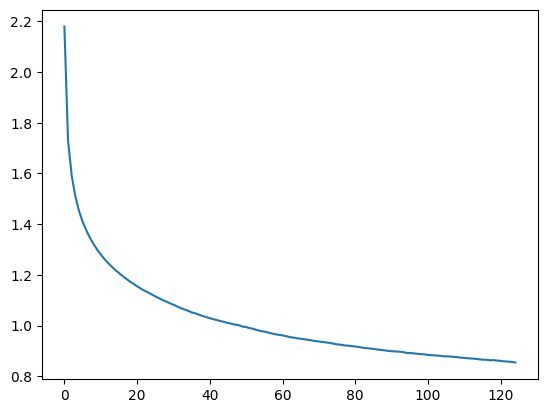

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(avg_loss_per_epoch)
